In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

<h2>Load Data</h2>

In [2]:
df = pd.read_csv('scraping/Data/CharacterLevelData/Characters.csv')
df.head()

,Id,Gender,Nickname,SkinUrl,Level,Profession,World,Guild,GuildId,PlayerId
0,363513,Male,Akceleratywny,www.margonem.pl/obrazki/postacie/woj/10/m_woj0...,180,Wojownik,Aldous,NaN,0,774087
1,363512,Male,Grzmotopędzik,www.margonem.pl/obrazki/postacie/woj/10/m_woj0...,210,Wojownik,Aldous,NaN,0,774087
2,381483,Male,odbijesechryzie,www.margonem.pl/obrazki/postacie/paid/grzyb_ou...,188,Mag,Aldous,NaN,0,774087
3,51462,Male,Socjopalista,www.margonem.pl/obrazki/postacie/woj/10/m_woj0...,290,Wojownik,Aldous,NaN,0,774087
4,48164,Male,Szczurołapek,www.margonem.pl/obrazki/postacie/paid/grzyb_ou...,300,Tancerz ostrzy,Aldous,NaN,0,774087


In [4]:
outfits = np.load('dataset.npy')
paths = pd.read_csv('scraping/Data/images_paths.csv').squeeze()
print(outfits.shape)
print(paths.shape)

(3862, 48, 32, 4)
(3862,)


In [5]:
print(outfits.min(), outfits.max())

-1.0 1.0


In [6]:
outfits = (outfits + 1.0) * 127.5
outfits = outfits.astype(int)

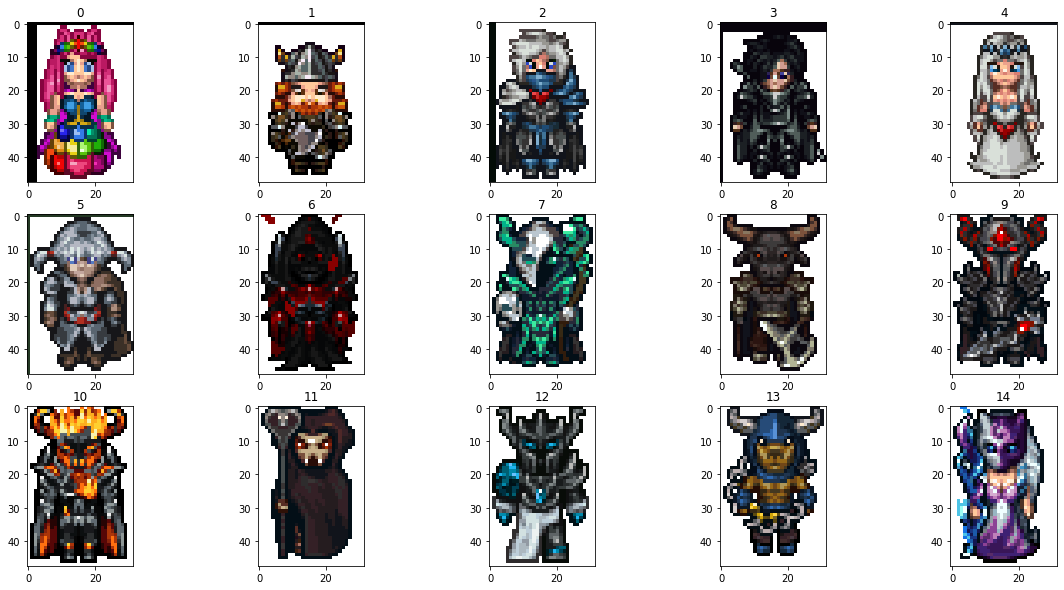

In [7]:
plt.figure(figsize=(20, 10))
for i in range(15):
      plt.subplot(3, 5, i+1)
      plt.title(i)
      plt.imshow(outfits[i])
plt.show()

<strong>Some images have dark bars at the image edges - should correct that</strong>

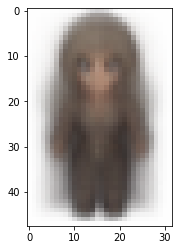

In [8]:
heatmap = outfits.mean(axis=0).astype(int)
plt.imshow(heatmap)

In [9]:
df.shape

(808601, 10)

In [10]:
paths.head()

0         Data/Skins/vip/587080_2.gif
1      Data/Skins/spec/valczemyna.gif
2    Data/Skins/clan/zorza_10200m.gif
3          Data/Skins/vip/3239014.gif
4    Data/Skins/clan/zorza_10200f.gif
Name: 0, dtype: object

In [11]:
df['SkinUrl'] = df['SkinUrl'].str.replace('www.margonem.pl/obrazki/postacie/', 'Data/Skins/')

In [12]:
df = df[df['SkinUrl'].isin(paths)] # because some images were dropped because they were duplicated
df.shape

(776562, 10)

<h2>Profession analysis</h2>

In [13]:
professions = df['Profession'].unique()
len(professions)

6

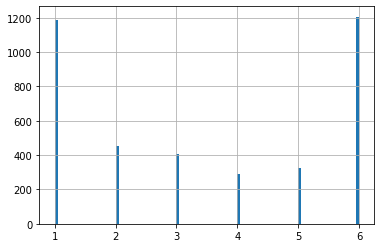

In [14]:
gb = df.groupby('SkinUrl')['Profession'].unique().str.len().hist(bins=100)

Some skins can be used for more than one character class

In [15]:
gb = df.groupby('SkinUrl')['Profession'].value_counts()
gb = gb / df.groupby('SkinUrl')['Profession'].count()
skin_class_encodings = gb.unstack(level=1).fillna(0.0)
print(skin_class_encodings.shape)
skin_class_encodings.head()

(3862, 6)


Profession,Mag,Paladyn,Tancerz ostrzy,Tropiciel,Wojownik,Łowca
SkinUrl,,,,,,
Data/Skins/bd/10/f_bd09.gif,0.0,0.0,0.999369,0.0,0.000631,0.0
Data/Skins/bd/10/f_bd18.gif,0.0,0.0,1.000000,0.0,0.000000,0.0
Data/Skins/bd/10/m_bd01.gif,0.0,0.0,1.000000,0.0,0.000000,0.0
Data/Skins/bd/10/m_bd04.gif,0.0,0.0,0.999824,0.0,0.000176,0.0
Data/Skins/bd/100/f_bd04.gif,0.0,0.0,1.000000,0.0,0.000000,0.0


In [16]:
skin_class_encodings = skin_class_encodings.reindex(paths)
skin_class_encodings.shape

(3862, 6)

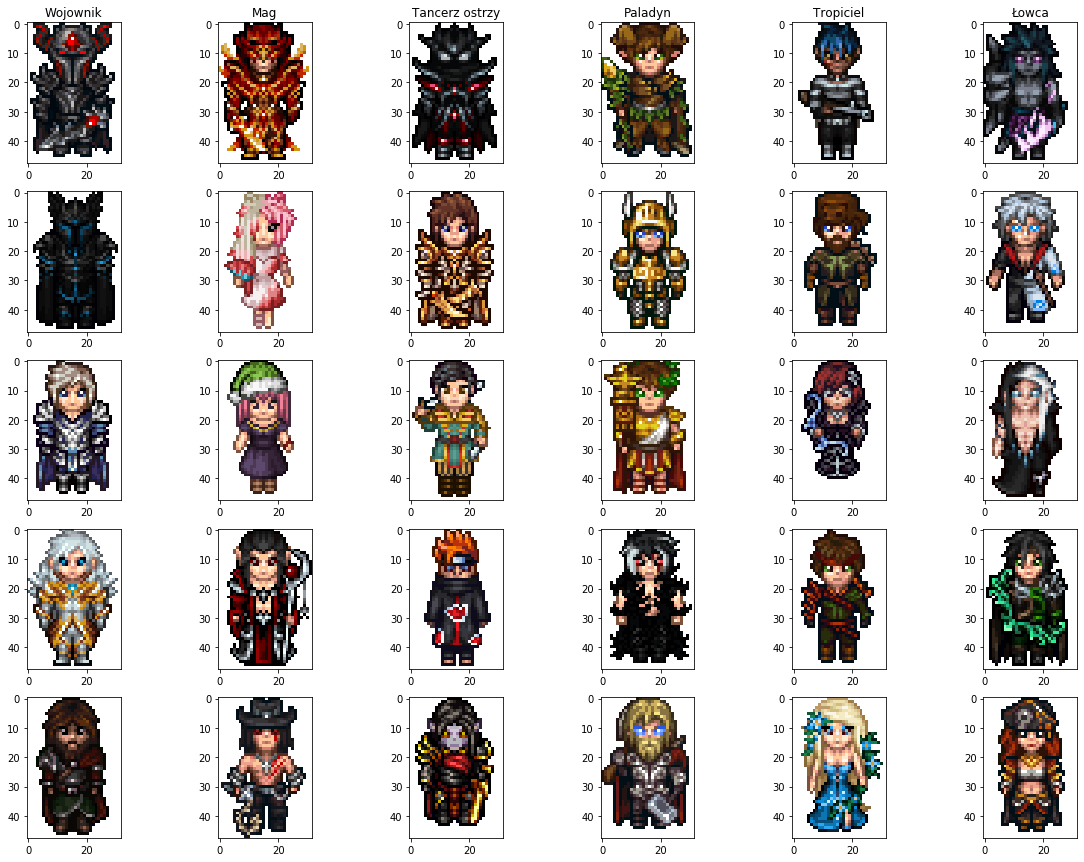

In [17]:
plt.figure(figsize=(20, 15))
eps = 0.1
for i in range(5 * len(professions)):
    plt.subplot(5, len(professions), i+1)
    if i < len(professions):
        plt.title(professions[i])
    profession_mask = skin_class_encodings[professions[i % len(professions)]] > 1.0 - eps
    plt.imshow(outfits[profession_mask][i])
plt.show()

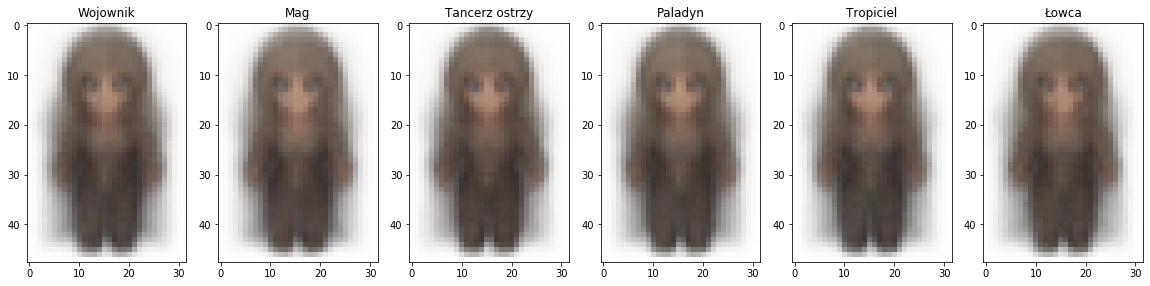

In [18]:
plt.figure(figsize=(20, 5))
eps = 0.1
for i in range(len(professions)):
    plt.subplot(1, len(professions), i+1)
    plt.title(professions[i])
    weights = np.array(skin_class_encodings[professions[i]]).reshape(-1, 1, 1, 1)
    profession_heatmap = (outfits * weights).sum(axis=0) / skin_class_encodings[professions[i]].sum()
    profession_heatmap = profession_heatmap.astype(int)
    plt.imshow(profession_heatmap)
plt.show()

It seems that outfits of given profession doesn't look much different from outfits of any other. Because of that it may be impossible to get a good model for profession prediction

<h2>Gender analysis</h2>

In [19]:
genders = df['Gender'].unique()
len(genders)

2

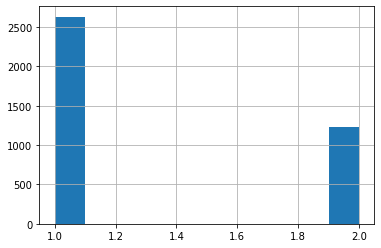

In [20]:
df.groupby('SkinUrl')['Gender'].unique().str.len().hist()

Some skins can be used by both genders.

In [21]:
gb = df.groupby('SkinUrl')['Gender'].value_counts()
gb = gb / df.groupby('SkinUrl')['Gender'].count()
skin_gender_encodings = gb.unstack(level=1).fillna(0.0)
skin_gender_encodings.head()

Gender,Female,Male
SkinUrl,,
Data/Skins/bd/10/f_bd09.gif,1.0,0.0
Data/Skins/bd/10/f_bd18.gif,1.0,0.0
Data/Skins/bd/10/m_bd01.gif,0.0,1.0
Data/Skins/bd/10/m_bd04.gif,0.0,1.0
Data/Skins/bd/100/f_bd04.gif,1.0,0.0


In [22]:
skin_gender_encodings = skin_gender_encodings.reindex(paths)
skin_gender_encodings.shape

(3862, 2)

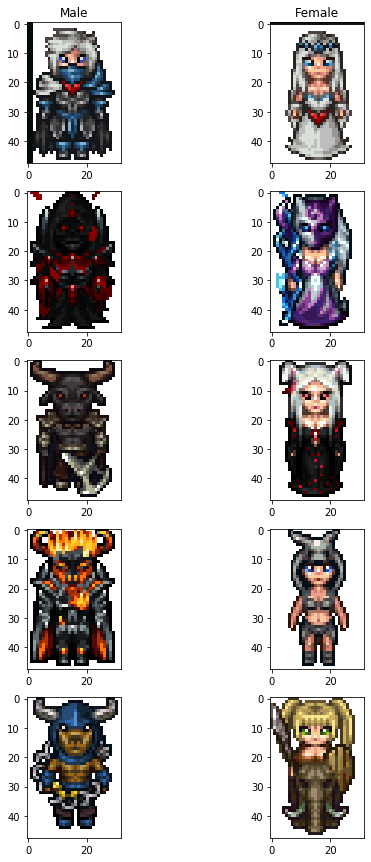

In [23]:
plt.figure(figsize=(8, 15))
eps = 0.1
for i in range(5 * len(genders)):
    plt.subplot(5, len(genders), i+1)
    if i < len(genders):
        plt.title(genders[i])
    gender_mask = skin_gender_encodings[genders[i % len(genders)]] > 1.0 - eps
    plt.imshow(outfits[gender_mask][i])
plt.show()

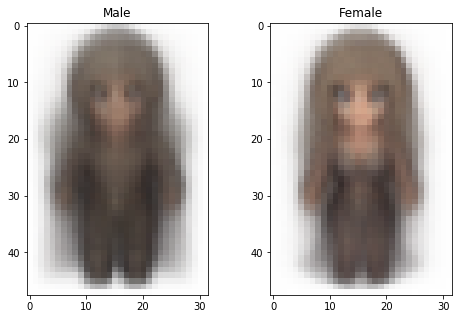

In [24]:
plt.figure(figsize=(8, 5))
eps = 0.1
for i in range(len(genders)):
    plt.subplot(1, len(genders), i+1)
    plt.title(genders[i])
    weights = np.array(skin_gender_encodings[genders[i]]).reshape(-1, 1, 1, 1)
    gender_heatmap = (outfits * weights).sum(axis=0) / skin_gender_encodings[genders[i]].sum()
    gender_heatmap = gender_heatmap.astype(int)
    plt.imshow(gender_heatmap)
plt.show()

<h2>Creating labels</h2>

In [25]:
skin_gender_encodings[(skin_gender_encodings['Female'] != 1.0) & (skin_gender_encodings['Female'] != 0.0)]

Gender,Female,Male
0,,
Data/Skins/spec/valczemyna.gif,0.117647,0.882353
Data/Skins/paid/kuf_wojbykm.gif,0.065972,0.934028
Data/Skins/spec/prorok.gif,0.109091,0.890909
Data/Skins/paid/kuf_xiii-low-m.gif,0.080882,0.919118
Data/Skins/spec/w18-outm3.gif,0.023810,0.976190
...,...,...
Data/Skins/spec/kaczka01.gif,0.022222,0.977778
Data/Skins/spec/donut.gif,0.250000,0.750000
Data/Skins/spec/sab20-robal.gif,0.066667,0.933333


In [26]:
encodings = skin_gender_encodings.join(skin_class_encodings)
encodings.index = 'https://' + encodings.index
encodings

,Female,Male,Mag,Paladyn,Tancerz ostrzy,Tropiciel,Wojownik,Łowca
0,,,,,,,,
https://Data/Skins/vip/587080_2.gif,1.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000
https://Data/Skins/spec/valczemyna.gif,0.117647,0.882353,0.000000,0.176471,0.235294,0.470588,0.058824,0.058824
https://Data/Skins/clan/zorza_10200m.gif,0.000000,1.000000,0.424242,0.242424,0.090909,0.060606,0.181818,0.000000
https://Data/Skins/vip/3239014.gif,0.000000,1.000000,0.000000,0.000000,0.571429,0.142857,0.285714,0.000000
https://Data/Skins/clan/zorza_10200f.gif,1.000000,0.000000,0.714286,0.142857,0.000000,0.000000,0.000000,0.142857
...,...,...,...,...,...,...,...,...
https://Data/Skins/spec/sab20-robal.gif,0.066667,0.933333,0.133333,0.200000,0.133333,0.266667,0.200000,0.066667
https://Data/Skins/spec/kupala05.gif,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
https://Data/Skins/spec/kupala01.gif,0.142857,0.857143,0.571429,0.285714,0.000000,0.000000,0.142857,0.000000


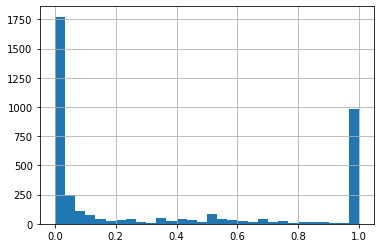

In [27]:
encodings['Female'].hist(bins=30)

In [28]:
encodings.to_csv('scraping/Data/SkinLabelsEncodings.csv')

<h2>Statistics</h2>

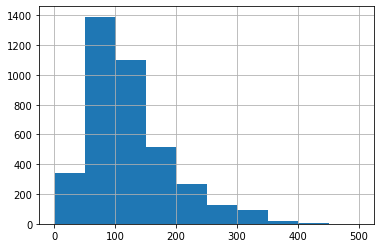

In [29]:
level_mean = df.groupby('SkinUrl')['Level'].mean()
level_mean.hist()

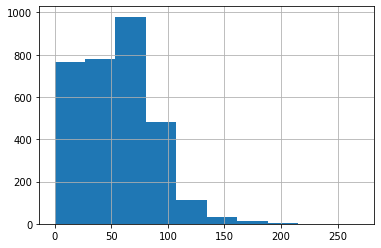

In [30]:
level_std = df.groupby('SkinUrl')['Level'].std()
level_std.hist()

In [31]:
statistics = pd.DataFrame({'LevelMean': level_mean, 'LevelStd': level_std})
statistics.head()

,LevelMean,LevelStd
SkinUrl,,
Data/Skins/bd/10/f_bd09.gif,23.070618,20.493657
Data/Skins/bd/10/f_bd18.gif,21.751515,18.608396
Data/Skins/bd/10/m_bd01.gif,24.501012,22.965886
Data/Skins/bd/10/m_bd04.gif,21.099156,18.200252
Data/Skins/bd/100/f_bd04.gif,131.000000,39.908549


In [32]:
statistics.to_csv('scraping/Data/SkinStatistics.csv')

In [33]:
stats_binned = statistics.copy()
stats_binned['LevelMean'] = pd.qcut(statistics['LevelMean'], 10, labels=False)
stats_binned['LevelStd'] = pd.qcut(statistics['LevelStd'], 10, labels=False)

In [34]:
stats_binned = stats_binned.reindex(paths)
stats_binned.head()

,LevelMean,LevelStd
0,,
Data/Skins/vip/587080_2.gif,6,8.0
Data/Skins/spec/valczemyna.gif,2,4.0
Data/Skins/clan/zorza_10200m.gif,2,0.0
Data/Skins/vip/3239014.gif,3,5.0
Data/Skins/clan/zorza_10200f.gif,2,0.0


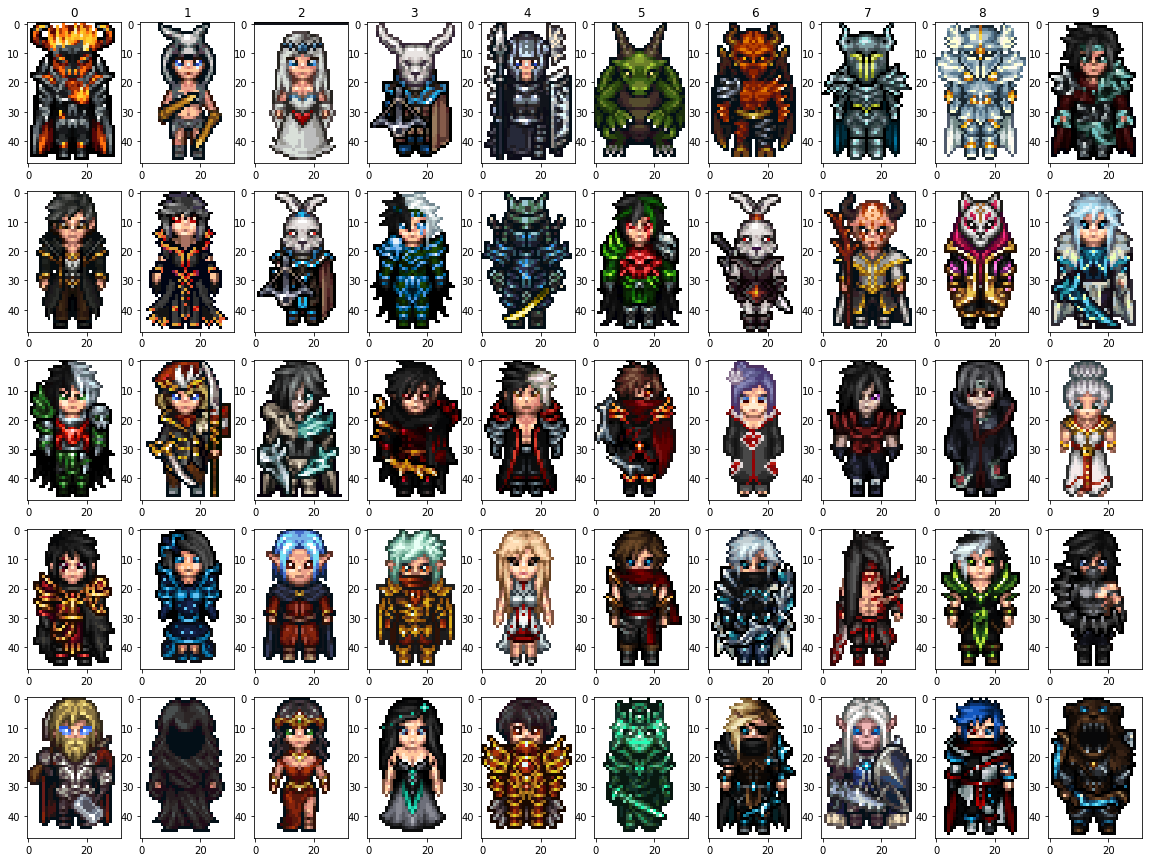

In [35]:
levels = sorted(stats_binned['LevelMean'].unique())
plt.figure(figsize=(20, 15))
eps = 0.1
for i in range(5 * len(levels)):
    plt.subplot(5, len(levels), i+1)
    if i < len(levels):
        plt.title(levels[i])
    current_bin_outfits = outfits[stats_binned['LevelMean'] == i % len(levels)]
    plt.imshow(current_bin_outfits[i])
plt.show()

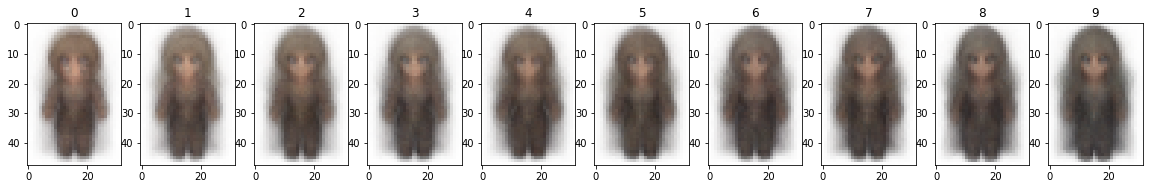

In [36]:
plt.figure(figsize=(20, 5))
eps = 0.1
for i in range(len(levels)):
    plt.subplot(1, len(levels), i+1)
    plt.title(levels[i])
    current_bin_outfits = outfits[stats_binned['LevelMean'] == i % len(levels)]
    plt.imshow(current_bin_outfits.mean(axis=0).astype(int))
plt.show()